<a href="https://colab.research.google.com/github/PnZheng/DeepLearning/blob/main/RNN/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

我们将使用PyTorch来训练RNN模型，来简单的实现文本分类任务(情感分析)。

- Input: 模型中将一段文本作为输入
- Output: 并输出'1'表示积极情绪，'0'表示消息情绪。  
- 在这里我们使用单层单向的RNN

一些必要的包的引入
- punctuation 和 Counter 用于文本处理、matplotlib用于展示数据
- numpy 用于数组操作、tqdm用于可视化进度条
- torchsummary用于展示网络的结构层次及相关数据

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 设置生成随机数的种子，保证实验的可重复性
torch.manual_seed(123)

# 数据集的操作:

- 你首先需要在这里下载数据集: https://ai.stanford.edu/~amaas/data/sentiment/
- 然后，需要将下载好的包解压到现在的工作目录下
- 解压完成后，会出一线一个名为"ac1Imdb"的文件出现在工作目录下
- 这个数据集是由一些电影评论作为文本输入的，并且有着相对应的情绪标签
- 此外，也可以使用下面的命令行进行下载数据

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar zxvf aclImdb_v1.tar.gz

### 读取文本文件中的情感标签和评论数据

In [2]:
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:04<00:00, 2595.67it/s]

Number of reviews : 25000


## 文件的预处理
- 将数据全转为小写
- 排除掉特殊字符
- 并将所有影评连接在一起后分组
- 记录词汇的频率

In [3]:
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

reviews_blob = ' '.join(review_list)

review_words = reviews_blob.split()
# get the word counts
count_words = Counter(review_words)

total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|█████████████████████████████████████████████████████████████████████████| 25000/25000 [00:02<00:00, 11887.06it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


### 将单词转化为数字序列，因为机器学习中模型仅对数字能理解解释，而并非单词


In [4]:
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


### 得到了单词对应的字典后，将原来的文本进行单词替换为数字。


In [5]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt

[22572, 321, 6, 3, 1077, 219, 8, 2082, 30, 1, 166, 61, 14, 46, 80, 5581, 42, 399, 118, 135, 14, 4883, 55, 4980, 147, 7, 1, 4941, 6023, 479, 69, 5, 255, 11, 22572, 17217, 1970, 6, 72, 2356, 5, 638, 70, 6, 4883, 1, 26241, 5, 2031, 10833, 

In [6]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

### 不同的review有不同 的长度，我们需要将他固定序列长度以定义简单的RNN模型， 这里设置Length = 512。

### 我们对过短的进行填补，对过长的进行裁剪。


(array([1.7708e+04, 5.3030e+03, 1.3860e+03, 5.3200e+02, 5.6000e+01,
        8.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10. ,  255.9,  501.8,  747.7,  993.6, 1239.5, 1485.4, 1731.3,
        1977.2, 2223.1, 2469. ]),
 <BarContainer object of 10 artists>)

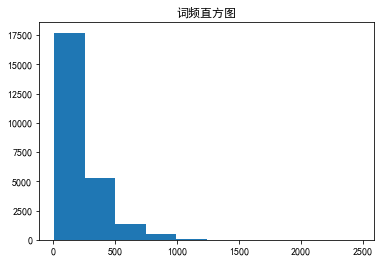

In [42]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)
# 展示直方图
plt.rcParams['axes.unicode_minus'] = False # 解决中文显示问题
plt.title(f'词频直方图')
plt.hist(reviews_len)

### 在这里，我们以75:25的比例将数据集分为训练集和验证集

In [8]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [9]:
## If while training, you get a runtime error that says: "RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long".
## simply uncomment run the following lines of code additionally
# train_X = train_X.astype('int64')
# train_y = train_y.astype('int64')
# validation_X = validation_X.astype('int64')
# validation_y = validation_y.astype('int64')

### 生成数据集及dataloader

In [10]:
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))

batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

### 取其中一个批次的数据显示看看


In [11]:
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,  4685,     1,  1464],
        [    0,     0,     0,  ...,  2342,     2,  2715],
        [    0,     0,     0,  ...,     7,    10,    19],
        ...,
        [    0,     0,     0,  ...,  1515,    29, 91311],
        [    0,     0,     0,  ...,    98,    80,    94],
        [    3,   335,    41,  ...,  1268,     2,    55]], device='cuda:0',
       dtype=torch.int32)

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.],
       device='cuda:0')


## RNN 模型的定义
- sequence shape = (sequence_length, batch_size)
- embedding shape = [sequence_length, batch_size, embedding_dimension]
- output shape = [sequence_length, batch_size, hidden_dimension]
- hidden_state shape = [1, batch_size, hidden_dimension]


In [12]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        embedding = self.embedding_layer(sequence)  
        output, hidden_state = self.rnn_layer(embedding)
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

### 优化函数 和 损失函数的定义

In [29]:
rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)
optim = torch.optim.Adam(rnn_model.parameters())

loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

#summary(rnn_model,np.asscalar(np.int16(1,3,28,28)))

### 定义准确度指标来衡量我们的训练模型在验证集上的性能


In [30]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

### 训练过程函数

In [31]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        # 清除梯度，以防上一次使用的参与这次训练之中
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

### 验证过程函数


In [32]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

## 开始训练模型并保存最好的模型参数

In [33]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    # 保存模型参数
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 45.824301958084106s
training loss: 0.616 | training accuracy: 67.24%
validation loss: 1.109 |  validation accuracy: 20.66%

epoch number: 2 | time elapsed: 42.594305753707886s
training loss: 0.529 | training accuracy: 74.04%
validation loss: 0.958 |  validation accuracy: 39.49%

epoch number: 3 | time elapsed: 42.712043046951294s
training loss: 0.437 | training accuracy: 80.68%
validation loss: 0.844 |  validation accuracy: 56.73%

epoch number: 4 | time elapsed: 42.7351713180542s
training loss: 0.370 | training accuracy: 84.52%
validation loss: 1.012 |  validation accuracy: 52.46%

epoch number: 5 | time elapsed: 42.71858263015747s
training loss: 0.306 | training accuracy: 87.91%
validation loss: 0.731 |  validation accuracy: 68.48%

epoch number: 6 | time elapsed: 42.67591142654419s
training loss: 0.244 | training accuracy: 90.79%
validation loss: 0.957 |  validation accuracy: 62.59%

epoch number: 7 | time elapsed: 42.66887354850769s
training loss: 0.

### 我们也可以定义一个辅助函数来对训练后的模型进行实时推理


In [34]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

### 对一些简单的句子进行预测

In [35]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.0002798324276227504
0.010395572520792484
0.04620944708585739
0.6425880789756775
0.22223013639450073


## 练习

- 在训练过程中，能够看到训练的准确度很高，但是验证的普遍较低，这是什么原因造成的？
- 如果我们通过修改Loss function后，结果会发送什么变化？
- 如果调整批大小后，本节的代码结果会发生变化？